# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [1]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [3]:
data_folder = "data"
data_filename = "data.csv"
data_path = join(data_folder, data_filename)

In [4]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [5]:
data.shape

(31390, 4)

EDA

31390 последовательность белка

In [6]:
print('Missing values:', data.isnull().sum())

Missing values: protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64


pH может быть 0, оставляем

In [7]:
print('Duplicates:', data.duplicated().sum())

Duplicates: 0


<AxesSubplot:xlabel='pH', ylabel='Count'>

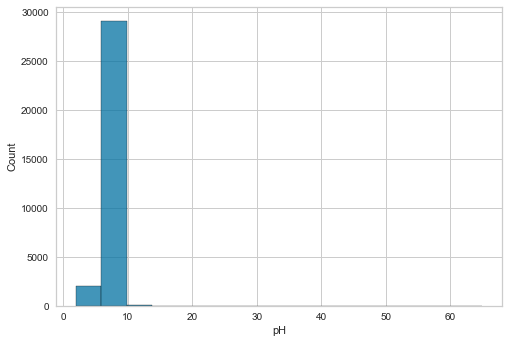

In [8]:
sns.histplot(data.pH)

<AxesSubplot:xlabel='tm', ylabel='Count'>

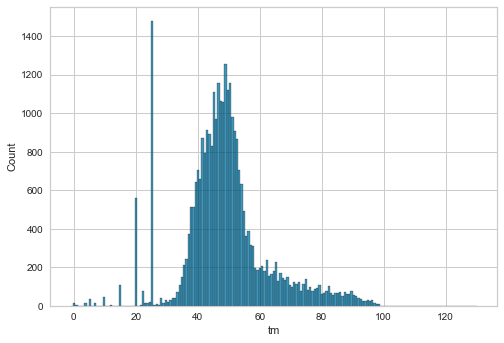

In [9]:
sns.histplot(data.tm)

In [10]:
for i in range(len(np.unique(data.pH))):
    print(i+1, str(np.unique(data.pH, return_counts=True)[1][i]))

1 2
2 111
3 3
4 3
5 13
6 9
7 4
8 1
9 12
10 19
11 1
12 274
13 15
14 1
15 3
16 1
17 1
18 5
19 2
20 1
21 288
22 55
23 2
24 2
25 2
26 5
27 1
28 2
29 2
30 1
31 56
32 1
33 4
34 2
35 20
36 4
37 6
38 3
39 17
40 1
41 34
42 1
43 60
44 3
45 5
46 29
47 43
48 45
49 2
50 3
51 11
52 2
53 217
54 4
55 69
56 1
57 37
58 1
59 12
60 2
61 176
62 11
63 5
64 164
65 3
66 58
67 13
68 9
69 104
70 4
71 57
72 208
73 54
74 97
75 45
76 31
77 12
78 30
79 12
80 26462
81 20
82 93
83 28
84 239
85 576
86 38
87 10
88 170
89 502
90 6
91 21
92 8
93 1
94 5
95 49
96 1
97 15
98 98
99 2
100 1
101 33
102 21
103 1
104 2
105 6
106 4
107 1
108 6
109 27
110 1
111 12
112 5
113 4
114 5
115 2
116 286


In [11]:
print(data.describe())

                 pH            tm
count  31104.000000  31390.000000
mean       6.892339     49.147337
std        1.612225     14.010089
min        1.990000     -1.000000
25%        7.000000     42.100000
50%        7.000000     48.000000
75%        7.000000     53.800000
max       64.900000    130.000000


In [12]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  31390 non-null  object 
 1   pH                31104 non-null  float64
 2   data_source       28043 non-null  object 
 3   tm                31390 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB
None


По tm, как мне кажется данные сопоставимы. По pH есть есть значительный выброс. Полагаю, это связано с тем, что этот pH - 7, нейтральный, самый распространенный(?) среди белков.

Однако, когда мало элементов в классе - плохо, надо избавляться

In [13]:
counts = data['tm'].value_counts()
print(counts)

25.0     1472
20.0      561
50.0      200
45.0      178
49.7      176
         ... 
98.1        1
97.6        1
92.7        1
1.2         1
103.0       1
Name: tm, Length: 770, dtype: int64


In [14]:
counts = data['tm'].value_counts()
data_2 = data.loc[data['tm'].isin(counts[counts > 6].index)]


In [15]:
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30812 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  30812 non-null  object 
 1   pH                30528 non-null  float64
 2   data_source       27553 non-null  object 
 3   tm                30812 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB
None


In [16]:
# create a LabelEncoder object
le = LabelEncoder()


le.fit(data_2['protein_sequence'])

# transform the data into encoded labels
data_2['protein_sequence_encoded'] = le.transform(data_2['protein_sequence'])

print(data_2)

                                         protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   
...                                                   ...  ...   
31385   YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...  7.0   
31386   YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...  7.0   
31387   YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...  7.0   
31388   YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...  7.0   
31389   YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...  7.0   

                              data_source    tm  protein_sequence_encoded  
seq_id                                                           

<ipython-input-16-893f54e8cd4a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['protein_sequence_encoded'] = le.transform(data_2['protein_sequence'])


In [17]:

le = LabelEncoder()


le.fit(data_2['pH'])


data_2['pH_encoded'] = le.transform(data_2['pH'])

print(data_2)

                                         protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   
...                                                   ...  ...   
31385   YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...  7.0   
31386   YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...  7.0   
31387   YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...  7.0   
31388   YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...  7.0   
31389   YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...  7.0   

                              data_source    tm  protein_sequence_encoded  \
seq_id                                                          

<ipython-input-17-97fe2538dcba>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['pH_encoded'] = le.transform(data_2['pH'])


In [18]:

le = LabelEncoder()


le.fit(data_2['tm'])


data_2['tm_encoded'] = le.transform(data_2['tm'])

print(data_2)

                                         protein_sequence   pH  \
seq_id                                                           
0       AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   
...                                                   ...  ...   
31385   YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...  7.0   
31386   YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...  7.0   
31387   YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...  7.0   
31388   YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...  7.0   
31389   YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...  7.0   

                              data_source    tm  protein_sequence_encoded  \
seq_id                                                          

<ipython-input-18-03ffa7ed49e7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['tm_encoded'] = le.transform(data_2['tm'])


А как кодировать? 

In [19]:
def integer_encode(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    encoding = [amino_acids.index(aa) + 1 for aa in sequence]
    return encoding

sequence = "ARNDCEQGHILKMFPSTWYV"
integer_encoded_sequence = integer_encode(sequence)

In [20]:
integer_encoded_sequence

[1, 15, 12, 3, 2, 4, 14, 6, 7, 8, 10, 9, 11, 5, 13, 16, 17, 19, 20, 18]

In [21]:
encoded_data_one_hot = pd.get_dummies(data_2, columns=['protein_sequence'])

In [22]:
encoded_data_one_hot.head()

,pH,data_source,tm,protein_sequence_encoded,pH_encoded,tm_encoded,protein_sequence_AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR,protein_sequence_AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS,protein_sequence_AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYATLGVAKNANGKDIKKAYYQLAKKYHPDTNKEDPDAGRKFQEVSEAYEVLSDEQKRREYDTYGQTAENIGRQGGGFPGGGAGGFGPEGFSQSWQFRSSIDPEELFRKIFGEGNFRTNSFDDFADSKFGFGQAQEMVMDLTFAQAARGVNKDVNVNVVDQCPKCAGTKCEPGTKPGRCQYCNGTGFETVSTGPFVMRSTCRYCQGTRQHIKYPCSECEGKGRTVQRRKVTVPVPAGIENGQTVRMQVGSKELFVTFRVERSDYFRREGADVHTDAAISLAQAVLGGTVRVQGVYEDQWINVEPGTSSHHKIMLRGKGLKRVNAHGHGDHYVHVKITVPSAKKLDKKRLALIEAYAELEEDTPGQIHGIANRKDGSKQATAGASEEPGAGAAAKASAAAAGSGASKPGPGAEESEGKDQWTDNKKTKAKEGGGSGSGQGDGGGGGFISKIKSMF,protein_sequence_AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLLQPPVPCACGCGALHTEGDKAFVEFLTDEIKEEKKIQKHKSLPKMSGDWELEVNGTEAKLLRKVAGEKITVTFNINNSIPPTFDGEEEPSQGQKAEEQEPELTSTPNFVVEVTKTDGKKTLVLDCHYPEDEIGHEDEAESDIFSIKEVSFQATGDSEWRDTNYTLNTDSLDWALYDHLMDFLADRGVDNTFADELVELSTALEHQEYITFLEDLKSFVKN,...,protein_sequence_YYAYVVELCVSTISRTGEKGKTVVYLVAFHLFFVMFVWSYWMTIFTSPASPSKEFYLSNSEKERYEKEFSQERQQDILRRAARDLPIYTTSASKAIRYCEKCQLIKPDRAHHCSACDRCVLKMDHHCPWVNNCVGFTNYKFFMLFLLYSLLYCLFVAATVLEYFIKFWTLCRRKSTENCPKNEPTVLNFPSAKFHVLFLFFVSAMFFVSVLSLFSYHCWLVGKNRTTIESFRAPMFSYGIDGNGFSLGCSKNWRQVFGDEKKYWLVPIFSSLGDGCSFPARLVGMDPEQASVANQSDYVRSIGSNQPFPIKPLSESKNRLLDSESQWLENGAEEGVTKSGTNNHVTVEIE,protein_sequence_YYLAAVKSMTQSFHNFFYASFDPSGFVTVDKPPVVLWIQTIFALIFGVHTWSVIIPQALAGVGSVFLLYRMVKPTFGVGAARIAALVMALTPIAVAVSRTNNIDSMLVFTLLLGSTCLLRAVKQGKLVWLLTAFALIGLAFNMKMMQAFMVLPAFVLFYLIASRVSLKKKIGSLLLSLVLLTGLSLSWAIAVDSASSSSRPYVGSSQTNSVLELAFGYNGTERLFGQTTGLAKGDMNAAGGGNMQNQDNMQAPNGNGSSFSQNGNQSFGNHSQAPQPPNGQTGALNGGGGTPPTGGNGPGNGGPGGGGGKSVNMFGTGDPGPLRLFQSALSGQISWMLPFSLIGLLGAIISWYRDRRGHAAKMKETLFWAAWLVPVAGFFSIAGFFHQYYLIMLAPPIAALSGIGWYTMHRLYKNNKDWSSYLLPAAVLITAVFQVYILSAYTSQIGSVWMYVLGLLGLGITLALLMLKRSHPFSKLLTIISLCVLLLTPVYWSATPLLYGGNSVLPESGPQLKGSANGGNMFSSEVDSGLLSYLRKHNTGEEYLFATLTTVTAAPYIIYENESVMAMGGFNGTDPILTVSELKKLIKEGKVKYFLLSENNSGNSELVSWIKKNGKEITSDEYSGSSSSTNSVQGMRRGPGGESQQTLYLV,protein_sequence_YYLKHQFYPTVVYLTKSSPSMAVLYIQAFVLVFLLGKVMGKVFFGQLRAAEMEHLLERSWYAVTETCLAFTVFRDDFSPRFVALFTLLLFLKCFHWLAEDRVDFMERSPNISWLFHCRIVSLMFLLGILDFLFVSHAYHSILTRGASVQLVFGFEYAILMTMVLTIFIKYVLHSVDLQSENPWDNKAVYMLYTELFTGFIKVLLYMAFMTIMIKVHTFPLFAIRPMYLAMRQFKKAVTDAIMSRRAIRNMNTLYPDATPEELQAVDNVCIICREEMVTGAKRLPCNHIFHTSCLRSWFQRQQTCPTCRMDVLRASLPAQSPPPPEPADQGPPPAPHPQPLLPQPPNFPQGLLPPFPPGMFPLWPPMGPFPPVPPPPSSGEAAAPPPTSTAVSRPSGAATTTAAGTSTSAPAPGSVPGPEAGPAPGFPFPPPWMGMPLPPPFAFPPMPVPPAGFAGLTPEELRALEGHERQHLEARLQSLRNIHTLLDAAMLQINQYLTVLASLGPPRPATSVNPTEETASTVVSAAPSTSAPSSEAPTPSPGASPPIPEAEKPPAPESVGIVEELPEDGEPDAAELRRRRLQKLESPVA,protein_sequence_YYLWHKAASTVASIHESIDKSKKRDKEVSINKKDPFSVLIMGVDERDGDKGRADTLIYMTVNPKTNTTDMVSIPRDTYTKIIGKGTMDKINHSYAFGGTQMTVDTVENFLDVPVDYFVKVNMESFRDVVDTLGGITVNSTFAFSYDGYSFGKGEITLNGKEALAYTRMRKEDPRGDFGRQDRQRQVIQGIINKGANISSITKFGDMFKVVENNVKTNLTFDNMWDIQSDYKGARKHIKQHELKGTGTKINGIYYYQADESALSDITKELKESLE,protein_sequence_YYLYGWNRGLEPSADASESDCGDPPPVAPSRLLPIKPVQAVAPSRTDPLVLVFVESLYSQLGQEVVAILESSRFKYRTEIAPGKGDMPTLTDKGRGRFALIIYENILKYVNLDAWNRELLDKYCVAYGVGIIGFFKANENSLLSAQLKGFPLFLHSNLGLKDCSINPKSPLLYVTRPSEVEKGVLPGEDWTVFQSNHSTYEPVLLAKTRSSESIPHLGADAGLHAALHATVVQDLGLHDGIQRVLFGNNLNFWLHKLVFVDAVAFLTGKRLSLPLDRYILVDIDDIFVGKEGTRMKVEDVKALFDTQNELRTHIPNFTFNLGYSGKFFHTGTDAEDAGDDLLLSYVKEFWWFPHMWSHMQPHLFHNQSVLAEQMALNKKFAVEHGIPTDMGYAVAPHHSGVYPVHVQLYEAWKQVWGIRVTSTEEYPHLKPARYRRGFIHNGIMVLPRQTCGLFTHTIFYNEYPGGSSELDKIINGGELFLTVLLNPISIFMTHLSNYGNDRLGLYTFKHLVRFLH

In [23]:
encoded_data_integer = data_2['protein_sequence'].apply(integer_encode)

In [24]:
encoded_data_integer.head()


seq_id
0    [1, 1, 1, 1, 9, 1, 1, 1, 10, 1, 10, 10, 6, 4, ...
1    [1, 1, 1, 3, 6, 4, 13, 10, 7, 12, 4, 4, 4, 15,...
2    [1, 1, 1, 5, 16, 17, 13, 15, 1, 17, 16, 20, 15...
3    [1, 1, 1, 16, 6, 10, 15, 17, 1, 8, 13, 1, 14, ...
4    [1, 1, 1, 17, 9, 16, 6, 13, 15, 15, 14, 16, 14...
Name: protein_sequence, dtype: object

Что ж, через integer мне кажется оптимальнее кодировать. 

Деление на train и test

По стратегии разбиения. Раз у нас большинство данных по pH представлены 7, нужно будет сделать так, чтобы в выборку train попали не только они. Стратификация?

In [25]:
combined_data = pd.concat([encoded_data_integer, data_2['pH_encoded']], axis=1)

In [26]:
combined_data_2 = pd.concat([combined_data, data_2['tm_encoded']], axis=1)

In [27]:
combined_data_2.head()

,protein_sequence,pH_encoded,tm_encoded
seq_id,,,
0,"[1, 1, 1, 1, 9, 1, 1, 1, 10, 1, 10, 10, 6, 4, ...",77,443
1,"[1, 1, 1, 3, 6, 4, 13, 10, 7, 12, 4, 4, 4, 15,...",77,191
2,"[1, 1, 1, 5, 16, 17, 13, 15, 1, 17, 16, 20, 15...",77,91
3,"[1, 1, 1, 16, 6, 10, 15, 17, 1, 8, 13, 1, 14, ...",77,158
4,"[1, 1, 1, 17, 9, 16, 6, 13, 15, 15, 14, 16, 14...",77,181


In [28]:
print(combined_data_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30812 entries, 0 to 31389
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   protein_sequence  30812 non-null  object
 1   pH_encoded        30812 non-null  int64 
 2   tm_encoded        30812 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 962.9+ KB
None


In [29]:
combined_data_3 = combined_data_2.dropna()

In [30]:
combined_data_3.head()

,protein_sequence,pH_encoded,tm_encoded
seq_id,,,
0,"[1, 1, 1, 1, 9, 1, 1, 1, 10, 1, 10, 10, 6, 4, ...",77,443
1,"[1, 1, 1, 3, 6, 4, 13, 10, 7, 12, 4, 4, 4, 15,...",77,191
2,"[1, 1, 1, 5, 16, 17, 13, 15, 1, 17, 16, 20, 15...",77,91
3,"[1, 1, 1, 16, 6, 10, 15, 17, 1, 8, 13, 1, 14, ...",77,158
4,"[1, 1, 1, 17, 9, 16, 6, 13, 15, 15, 14, 16, 14...",77,181


Что ж уже здесь возникли проблемы с векторизированными белками, поэтому пока пришлось от них отказаться

In [31]:
X, y = combined_data_3[['pH_encoded']], combined_data_3['tm_encoded']

In [32]:
y

seq_id
0        443
1        191
2         91
3        158
4        181
        ... 
31385    204
31386     58
31387    332
31388    193
31389     62
Name: tm_encoded, Length: 30812, dtype: int64

In [33]:
X

,pH_encoded
seq_id,
0,77
1,77
2,77
3,77
4,77
...,...
31385,77
31386,77
31387,77


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=42,
                                                    stratify=y)

In [35]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [   6    8   20   12   17   16   76  393   49    5    8 1030   22   14
    6    6    7    6    6    5    6   13    6   13    7    8   12    9
    8    6   14   12   25   11   10   14   17   16   12   13   21   18
   17   20   18   21   18   25   20   22   20   23   24   36   36   29
   48   36   36   37   40   37   55   45   54   45   41   35   45   53
   53   48   49   48   53   54   56   55   59   62   56   57   50   57
   59   80   90   62   72   69   62   60   63   64   59   58   78   76
   76   63   71   60   79   78   85   97   91   78   90   80   64   73
   80   92   80   69   79   78   90   77   74   92   82   94   71   78
  101  107   88   82   78   90   85   82   76   82  125   91   90   94
   96  105   94   85   99   90  110   90  108   96   93  110  104   93
  100  115  108   84  100  104  110  114  104  103  110  104  108  111
   97   92  122  108  116  115  113  101  122  111   95  104  108  105
  112  123  102   94  140  113   92  1

In [36]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                    train_size=0.5, 
                                                    random_state=42,
                                                    stratify=y_test)

Ащ

In [37]:
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
print(f"Количество строк в y_val по классам: {np.bincount(y_val)}")

Количество строк в y_test по классам: [  1   1   4   3   3   3  16  84  11   1   2 221   5   3   2   1   1   1
   1   1   1   3   1   3   2   2   3   2   2   1   3   2   6   2   2   3
   4   3   3   3   5   4   4   4   4   4   4   6   4   5   5   5   5   7
   8   6  11   8   7   8   9   8  12  10  12   9   9   7  10  12  12  10
  11  10  12  11  12  12  12  13  12  13  11  12  13  17  19  13  15  14
  13  13  14  14  12  12  17  17  17  13  15  13  17  16  18  21  19  16
  19  17  13  16  17  19  17  14  17  17  20  17  16  20  17  20  15  16
  22  23  19  17  17  19  18  17  16  17  26  20  20  21  21  23  20  18
  21  19  23  19  24  21  20  24  23  20  22  25  24  18  22  22  23  25
  22  22  24  22  23  24  21  20  26  23  25  25  24  22  26  23  21  22
  23  23  24  27  22  20  30  25  19  26  22  19  22  22  19  21  22  21
  21  20  20  21  17  19  17  23  25  19  16  17  19  17  16  14  16  14
  16  13  14  17  18  18  13  13  14  12  14  11  11  11  10  13  12   9
   8  10  16 

Кросс-валидация, поиск лучшей модели

Обучение без учителя

In [38]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_k

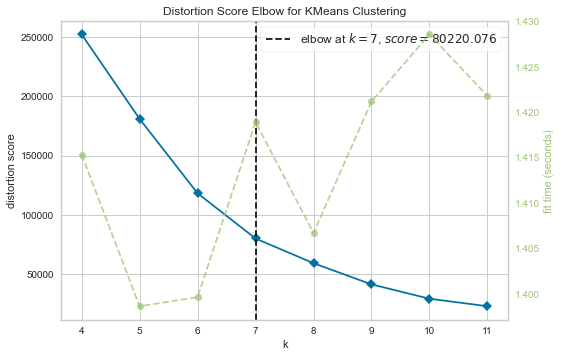

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
visualizer.fit(X)
visualizer.show()

In [40]:
# create a KMeans 
kmeans = KMeans(n_clusters=7)


kmeans.fit(X)


print(kmeans.labels_)

d:\programmes\miniconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 0 0 ... 0 0 0]


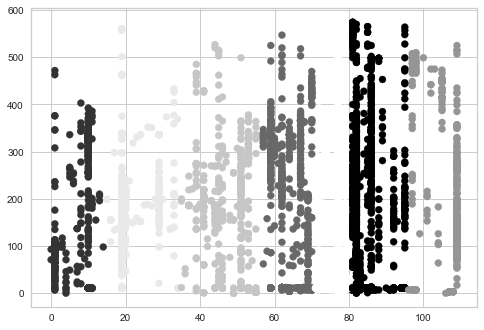

In [41]:
plt.scatter(X, y, c=kmeans.labels_)
plt.show()

In [203]:
model_2 = AgglomerativeClustering()
visualizer = KElbowVisualizer(model_2, k=(4,12))

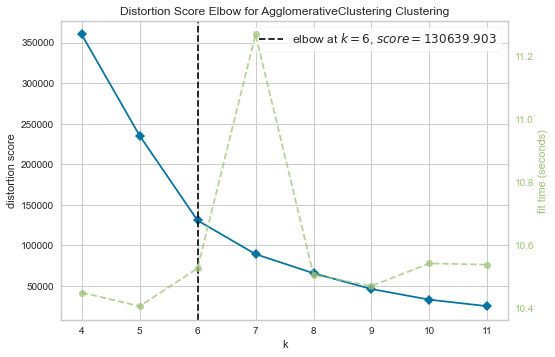

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [204]:
visualizer.fit(X)
visualizer.show()

In [205]:
###### create an AgglomerativeClustering 
hierarchical = AgglomerativeClustering(n_clusters=6)


hierarchical.fit(X)


print(hierarchical.labels_)

[5 5 5 ... 5 5 5]


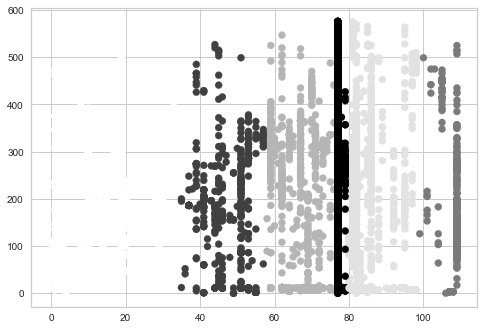

In [206]:
plt.scatter(X, y, c=hierarchical.labels_)
plt.show()

Обучение с учитилем


In [40]:
numpy_array = combined_data_3.to_numpy()

In [41]:
X_2, y_2 = numpy_array[:, 1], numpy_array[:, 2]

In [42]:
X_2

array([77, 77, 77, ..., 77, 77, 77], dtype=object)

In [43]:
y_2.reshape(-1, 1)

array([[443],
       [191],
       [91],
       ...,
       [332],
       [193],
       [62]], dtype=object)

In [44]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    random_state=42,
                                                    stratify=y)

In [47]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}



In [48]:
# Create a Random Forest object
rf = RandomForestRegressor()


random_search = RandomizedSearchCV(rf, param_grid)


random_search.fit(X_train_2, y_train_2)


print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegr

d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegr

Best parameters:  {'n_estimators': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Best score:  0.04426129705740871


In [49]:
rfc = RandomForestRegressor(n_estimators=20, max_depth=8, min_samples_split=5, min_samples_leaf=1, max_features='auto', bootstrap=1)

In [50]:
rfc.fit(X_train_2, y_train_2)

d:\programmes\miniconda\lib\site-packages\sklearn\utils\_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
d:\programmes\miniconda\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(bootstrap=1, max_depth=8, max_features='auto',
                      min_samples_split=5, n_estimators=20)

[Text(0.39747807017543857, 0.9444444444444444, 'x[0] <= 69.5\nsquared_error = 13556.145\nsamples = 13617\nvalue = 181.364'),
 Text(0.21271929824561403, 0.8333333333333334, 'x[0] <= 67.5\nsquared_error = 17199.983\nsamples = 996\nvalue = 160.676'),
 Text(0.14473684210526316, 0.7222222222222222, 'x[0] <= 4.5\nsquared_error = 16977.542\nsamples = 898\nvalue = 174.305'),
 Text(0.06140350877192982, 0.6111111111111112, 'x[0] <= 3.5\nsquared_error = 9989.008\nsamples = 57\nvalue = 103.118'),
 Text(0.043859649122807015, 0.5, 'x[0] <= 2.0\nsquared_error = 10583.5\nsamples = 50\nvalue = 114.488'),
 Text(0.02631578947368421, 0.3888888888888889, 'squared_error = 10716.545\nsamples = 49\nvalue = 114.595'),
 Text(0.06140350877192982, 0.3888888888888889, 'squared_error = 0.0\nsamples = 1\nvalue = 106.0'),
 Text(0.07894736842105263, 0.5, 'squared_error = 640.13\nsamples = 7\nvalue = 33.154'),
 Text(0.22807017543859648, 0.6111111111111112, 'x[0] <= 66.5\nsquared_error = 17089.03\nsamples = 841\nvalue =

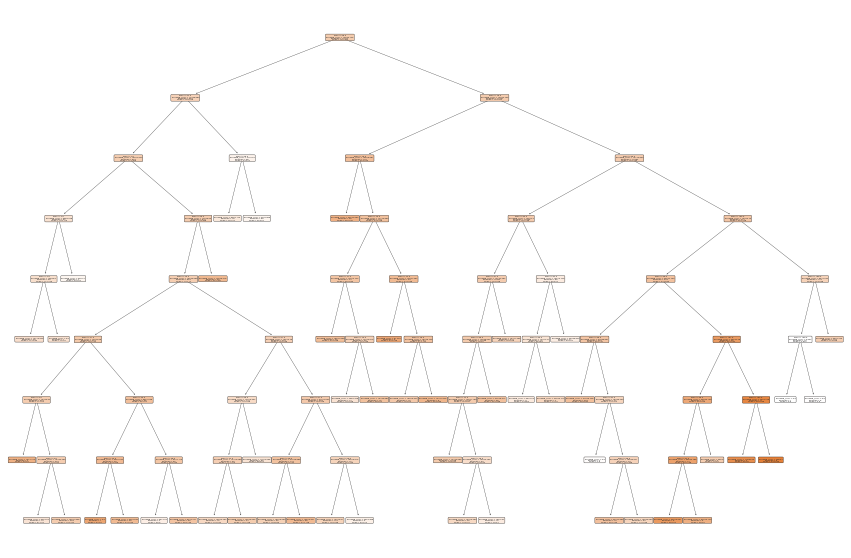

In [51]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rfc.estimators_[0], 

          filled=True, impurity=True, 
          rounded=True)

In [52]:
y_pred = rfc.predict(X_test_2)

In [53]:
accuracy_score(y_test_2, y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

Рум-пум-пум, что ж 

In [55]:
param_grid_3 = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [5000]
}


In [56]:
clf = MLPClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(clf, param_grid=param_grid_3, cv=5, )
grid_search.fit(X, y)

d:\programmes\miniconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [171]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

    fruit  fruit_encoded
0   apple              0
1  banana              1
2  orange              2
3   apple              0
4  orange              2


Еще одно рум пум-пум

In [45]:

param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create an SVM object
svm = SVC()


grid_search = GridSearchCV(svm, param_grid)


grid_search.fit(X, y)


print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

KeyboardInterrupt: 

Завершающее рум пум-пум

Обучение на всех тренировачных данных

Тест